In [1]:
!pip install xlrd openpyxl seaborn

     |████████████████████████████████| 96 kB 3.1 MB/s eta 0:00:011
     |████████████████████████████████| 242 kB 9.1 MB/s eta 0:00:01
     |████████████████████████████████| 292 kB 10.7 MB/s eta 0:00:01
     |████████████████████████████████| 39.8 MB 16.3 MB/s eta 0:00:01


In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.legend import _get_legend_handles_labels

In [3]:
data_map = {
  "biomass": {
    "emission": {
      "emission": ["GHG_FDupstream_low", "Base_GHGemissions", "GHG_FDupstream_high"],
      "cost": ["Avoided cost_FDupstream_low", "Base_AvoidedCost", "Avoided cost_FDupstream_high"]
    },
    "avoided_cost": {
      "y_data": ["AvoidedCost_FdCost_low", "Base_AvoidedCost", "AvoidedCost_FdCost_high"],
      "x_data": [6.27, 8.84, 11.40]
    }
  },
  "naphtha": {
    "emission": {
      "emission": ["GHG_FDupstream_low", "Base_GHGemissions", "GHG_FDupstream_high"],
      "cost": ["Avoided cost_FDupstream_low", "Base_AvoidedCost", "Avoided cost_FDupstream_high"]
    },
    "avoided_cost": {
      "y_data": ["AvoidedCost_FdCost_low", "Base_AvoidedCost", "AvoidedCost_FdCost_high"],
      "x_data": [523.18, 747.40, 971.62]
    }
  },
  "natural_gas": {
    "emission": {
      "emission": ["GHG_NGupstream_low", "Base_GHGemissions", "GHG_NGupstream_high"],
      "cost": ["Avoided cost_NGupstream_low", "Base_AvoidedCost", "Avoided cost_NGupstream_high"]
    },
    "avoided_cost": {
      "y_data": ["AvoidedCost_NGCost_low", "Base_AvoidedCost", "AvoidedCost_NGCost_high"],
      "x_data": [3.60, 10.44, 13.77]
    }
  },
  "electricity": {
    "emission": {
      "emission": ["GHG_ELECupstream_low", "Base_GHGemissions", "GHG_ELECupstream_high"],
      "cost": ["Avoided cost_ELECupstream_low", "Base_AvoidedCost", "Avoided cost_ELECupstream_high"]
    },
    "avoided_cost": {
      "y_data": ["AvoidedCost_ElecCost_low", "Base_AvoidedCost", "AvoidedCost_ElecCost_high"],
      "x_data": [20.13, 26.17, 32.21]
    }
  },
  "cap_opx_lab": {
    "emission": None,
    "avoided_cost": {
      "y_data": ["AvoidedCost_CapOpxLab_low", "Base_AvoidedCost", "AvoidedCost_CapOpxLab_high"],
      "x_data": [0.25, 0.5, 0.75]
    }
  },
  "co2_ts": {
    "emission": None,
    "avoided_cost": {
      "y_data": ["AvoidedCost_CO2TScost_low", "Base_AvoidedCost", "AvoidedCost_CO2TScost_high"],
      "x_data": [10.80, 13.05, 77.63]
    }
  },
  "combined": {
    "emission": {
      "emission": ["GHG_UpsreamCombi_low", "Base_GHGemissions", "GHG_UpsreamCombi_high"],
      "cost": ["Avoided cost_UpsreamCombi_low", "Base_AvoidedCost", "Avoided cost_UpsreamCombi_high"]
    },
    "avoided_cost": {
      "y_data": ["Avoided cost_AllCombi_low", "Base_AvoidedCost", "Avoided cost_AllCombi_high"],
      "x_data": [0.25, 0.5, 0.75]
    }
  },
  "combined_cost": {
    "emission": None,
    "avoided_cost": {
      "y_data": ["AvoidedCost_CombinedCost_low", "Base_AvoidedCost", "AvoidedCost_CombinedCost_high"],
      "x_data": [0.25, 0.5, 0.75]
    }
  },
  "combined_emit_cost": {
    "emission": {
      "emission": ["GHG_UpsreamCombi_low", "Base_GHGemissions", "GHG_UpsreamCombi_high"],
      "cost": ["Avoided cost_AllCombi_low", "Base_AvoidedCost", "Avoided cost_AllCombi_high"]
    },
    "avoided_cost": None
  },
  
}


In [4]:
def fetch_data(item: str, data_map: dict, dbpath: str, scale: bool = True):
    """Fetch cost data"""
    # All avoided cost
    db = pd.read_excel(dbpath, header=1, index_col=0)

    # Emission
    emission = data_map[item]["emission"]
    
    emit_df = None
    if emission:
        emit_df = db.loc[:, emission["emission"] + emission["cost"]]
    
    avoided_cost = data_map[item]["avoided_cost"]
    
    # Avoided cost
    avct_df, ct_fcts = None, None
    if avoided_cost:
        avct_df = db.loc[:, avoided_cost["y_data"]]
    
        # Item scales
        ct_fcts = avoided_cost["x_data"]
        if scale:
            ct_fcts = pd.Series([x / ct_fcts[1] for x in avoided_cost["x_data"]],
                                index=["lower", "mid", "upper"])

    return emit_df, (avct_df, ct_fcts)


In [5]:
def plot_vbar(data, figsize=(12, 6)):
    # Colors for two axies
    lf_color, rt_color = "#8491B4", "#F39B7F"

    # How many axes (one per method)?
    nrows, _ = data.shape
    fig, axes = plt.subplots(ncols=nrows)
    
    # TODO: a function to make this step easier.
    pad_fct = 0.1
    rt_ymax, rt_ymin = data.iloc[:, :3].max().max(), data.iloc[:, :3].min().min()
    rt_ydif = rt_ymax - rt_ymin
    rt_ylim = (min(0, rt_ymin - pad_fct * rt_ydif), rt_ymax + pad_fct * rt_ydif)

    lf_ymax, lf_ymin = data.iloc[:, 3:].max().max(), data.iloc[:, 3:].min().min()
    lf_ydif = lf_ymax - lf_ymin
    lf_ylim = (min(0, lf_ymin - pad_fct * lf_ydif), lf_ymax + pad_fct * lf_ydif)
    
    # Plot each method.
    for idx, mtd in enumerate(data.index):
        # Low, base, high cost/emission
        x_level = ["L", "W", "H"]

        # Avoided cost, left y-axis
        y_cost = data.iloc[idx, 3:].fillna(0)
        lf_axe = axes[idx]
        lf_axe.bar(x_level, y_cost, color=lf_color)

        # Emission, right y-axis
        cur_size = plt.rcParams['lines.markersize'] ** 2
        if idx == 0:
            dot_size = [0, cur_size, 0]
        else:
            dot_size = [cur_size] * 3

        y_emit = data.iloc[idx, :3].fillna(0)
        rt_axe = axes[idx].twinx()
        rt_axe.scatter(x_level, y_emit, s=dot_size, color=rt_color)
        
        # Make sure the axis, y-ticks display correctly
        rt_axe.spines["top"].set_visible(False)
        lf_axe.spines["top"].set_visible(False)
        if idx == 0:
            lf_axe.spines["right"].set_visible(False)
            lf_axe.set_ylabel("Avoided Cost (\$ / t $CO_{2eq}$)")
            lf_axe.tick_params(axis="y", labelcolor=lf_color, )
            rt_axe.spines["right"].set_visible(False)
            rt_axe.set_yticks([])
        elif 0 < idx < nrows - 1:
            lf_axe.spines["left"].set_visible(False)
            lf_axe.spines["right"].set_visible(False)
            lf_axe.set_yticks([])
            rt_axe.spines["left"].set_visible(False)
            rt_axe.spines["right"].set_visible(False)
            rt_axe.set_yticks([])
        else:
            lf_axe.spines["left"].set_visible(False)
            lf_axe.set_yticks([])
            rt_axe.spines["left"].set_visible(False)
            rt_axe.set_ylabel("Emission ($CO_{2eq}$ / t aromatics)")
            rt_axe.tick_params(axis="y", labelcolor=rt_color)
        
        # Force each axe show the same sacle, sort of shared y
        lf_axe.set_ylim(lf_ylim)
        rt_axe.set_ylim(rt_ylim)

        # Per method per axe
        lf_axe.set_xlabel(mtd)

    fig_wd, fig_ht = figsize
    fig.set_figwidth(fig_wd)
    fig.set_figheight(fig_ht)


In [6]:
def plot_line(y_data, x_data, figsize = (7, 7), broken: bool = False):
    assert y_data.shape[1] == 3, "The y_data should have exact three columns!"
    assert x_data.shape[0] == 3, "The x_data should have three elements!"
    
    fig, axe = plt.subplots()

    # For the diagonal lines
    d = 0.6
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=10, linestyle="none",
                  color="0", mec="0", mew=1, clip_on=False, lw=0.5)
    
    y_min, y_max = y_data.min().min(), y_data.max().max()
    y_lim_diff = y_max - y_min

    lower, base, upper = y_data.columns

    y_sec_max = y_data.nlargest(2, upper).loc[:, upper].min()
    y_sec_min = y_data.nsmallest(2, lower).loc[:, lower].max()
    y_sec_dif = y_sec_max - y_sec_min

    if broken:
        up_axe = axe.inset_axes([0, 0.87, 1, 0.15])
        up_axe.set_xticks([])
        up_axe.spines["bottom"].set_visible(False)

        md_axe = axe.inset_axes([0, 0.17, 1, 0.68])
        md_axe.set_xticks([])
        md_axe.spines["top"].set_visible(False)
        md_axe.spines["bottom"].set_visible(False)

        dw_axe = axe.inset_axes([0, 0.0, 1, 0.15])
        dw_axe.spines["top"].set_visible(False)
    # Otherwise, we set them as None, then the later will plot only on 
    # axe for the data.
    else:
        up_axe, md_axe, dw_axe = None, None, None

    # We need to set the ylim according to the axe position
    # For up_axe, the y max lim is the maximum of the data, while the y min
    # lim is determined by the relative size of md_axe
    if up_axe and md_axe and dw_axe:
        # A padding factor for upper lim (up_axe) or lower lim (dw_axe)
        pd_fct = 0.125

        y_bd_dif = y_sec_dif * 0.15 / 0.7
        dw_axe_y_lim = (y_min - y_bd_dif * pd_fct, y_min + y_bd_dif)
        up_axe_y_lim = (y_max - y_bd_dif, y_max + y_bd_dif * pd_fct)

    for mthd_idx, method in enumerate(y_data.index):
        per_avcs = y_data.iloc[mthd_idx, :]

        if method == "NACR":
            continue

        axe.scatter(x_data, per_avcs, label=method)
        axe.plot(x_data, per_avcs)
        axe.spines["top"].set_visible(False)
        axe.spines["right"].set_visible(False)

        if mthd_idx == 1:
            axe.set_ylabel("Avoided Cost (\$ / t $CO_{2eq}$)", labelpad=25)

        if up_axe and md_axe and dw_axe:
            axe.set_xticks([])
            axe.set_yticks([])
            axe.set_frame_on(False)

            up_axe.plot(x_data, per_avcs)
            up_axe.scatter(x_data, per_avcs)
            up_axe.set_ylim(up_axe_y_lim)
            up_axe.tick_params(axis="y", labelcolor="blue")
            up_axe.plot([0], [0], transform=up_axe.transAxes, **kwargs) # Bottom diagnoal
            up_axe.spines["top"].set_visible(False)
            up_axe.spines["right"].set_visible(False)
            
            md_axe.plot(x_data, per_avcs, label=method)
            md_axe.scatter(x_data, per_avcs)
            md_axe_y_lim = [y_sec_min - y_sec_dif * 0.125,
                            y_sec_max + y_sec_dif * 0.125]
            md_axe.set_ylim(md_axe_y_lim)
            md_axe.plot([0], [1], transform=md_axe.transAxes, **kwargs) # Top diagnoal
            md_axe.plot([0], [0], transform=md_axe.transAxes, **kwargs) # Bottom diagnoal
            md_axe.spines["right"].set_visible(False)

            dw_axe.plot(x_data, per_avcs)
            dw_axe.scatter(x_data, per_avcs)
            dw_axe.set_ylim(dw_axe_y_lim)
            dw_axe.tick_params(axis="y", labelcolor="blue")
            dw_axe.plot([0], [1], transform=dw_axe.transAxes, **kwargs) # Top diagnoal
            dw_axe.spines["right"].set_visible(False)
            axe.set_ylim([-10000, 10000]) # make sure the lim is large enough to be covered by md_axe
            
    fig_wd, fig_ht = figsize
    fig.set_figwidth(fig_wd)
    fig.set_figheight(fig_ht)

    fig.legend(bbox_to_anchor=(1.1, 0.75))


In [7]:
# Workspace variables
# wk_dir = os.path.join(os.environ["HOME"], "Documents/projects/wp_supply_chain")
dbpath = f"./Sensitivity analysis.xlsx"

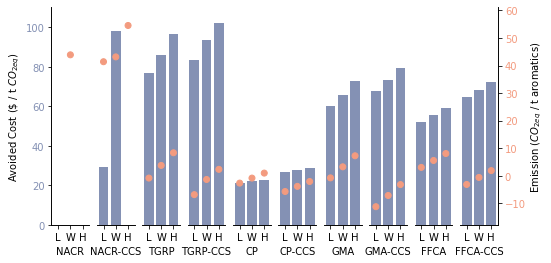

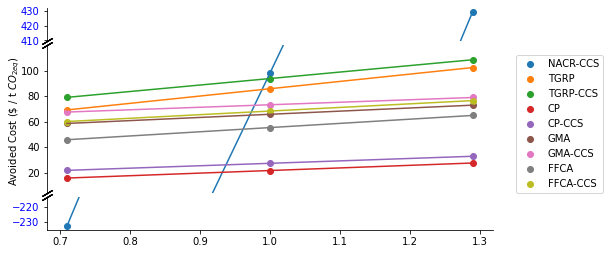

In [8]:
item = "biomass"
emit, avct = fetch_data(item, data_map, dbpath)

if emit is not None: # some emission data are not available
    plot_vbar(emit, (8, 4))

if all([x is not None for x in avct]):
    plot_line(*avct, (8, 4), broken=True)

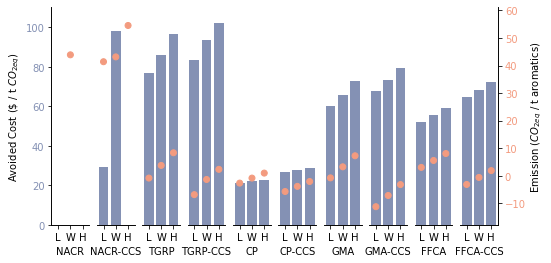

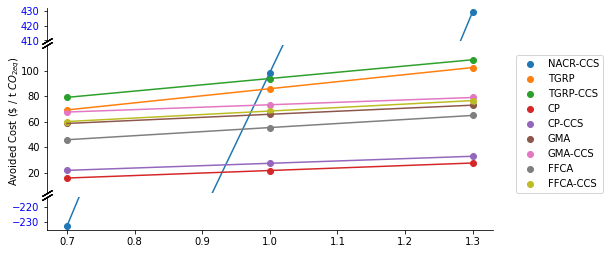

In [9]:
item = "naphtha"
emit, avct = fetch_data(item, data_map, dbpath)

if emit is not None: # some emission data are not available
    plot_vbar(emit, (8, 4))

if all([x is not None for x in avct]):
    plot_line(*avct, (8, 4), broken=True)

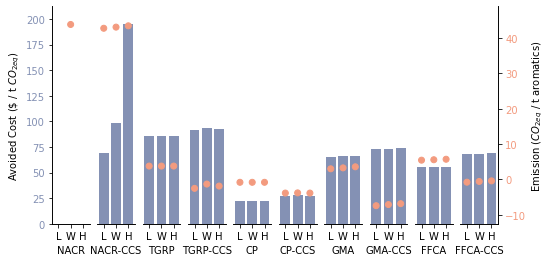

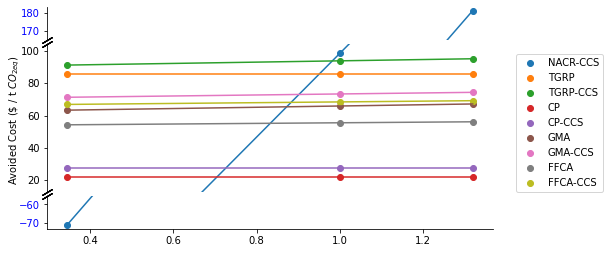

In [10]:
item = "natural_gas"
emit, avct = fetch_data(item, data_map, dbpath)

if emit is not None: # some emission data are not available
    plot_vbar(emit, (8, 4))

if all([x is not None for x in avct]):
    plot_line(*avct, (8, 4), True)

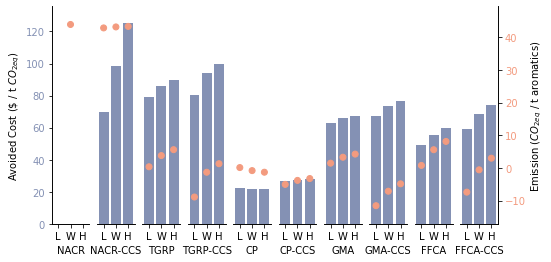

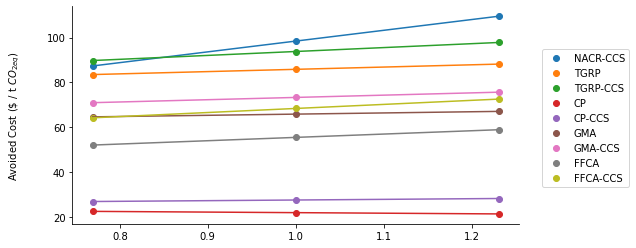

In [11]:
item = "electricity"
emit, avct = fetch_data(item, data_map, dbpath)

if emit is not None: # some emission data are not available
    plot_vbar(emit, (8, 4))

if all([x is not None for x in avct]):
    plot_line(*avct, (8, 4))

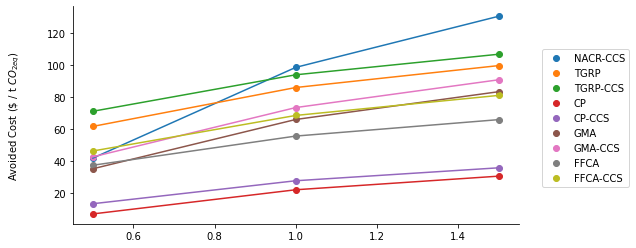

In [12]:
item = "cap_opx_lab"
emit, avct = fetch_data(item, data_map, dbpath)

if emit is not None: # some emission data are not available
    plot_vbar(emit, (8, 4))

if all([x is not None for x in avct]):
    plot_line(*avct, (8, 4))

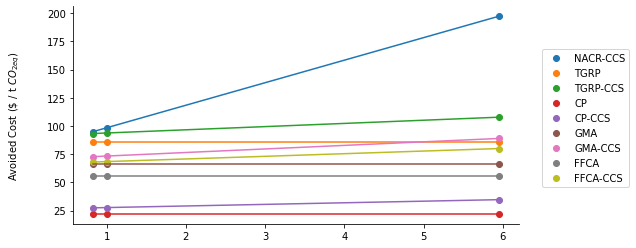

In [13]:
item = "co2_ts"
emit, avct = fetch_data(item, data_map, dbpath)

if emit is not None: # some emission data are not available
    plot_vbar(emit, (8, 4))

if all([x is not None for x in avct]):
    plot_line(*avct, (8, 4))

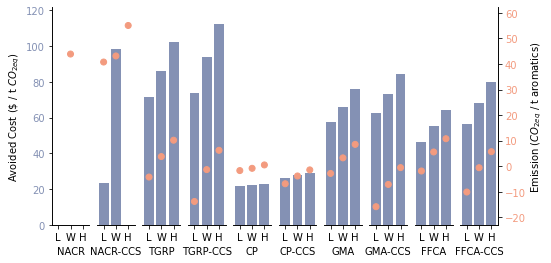

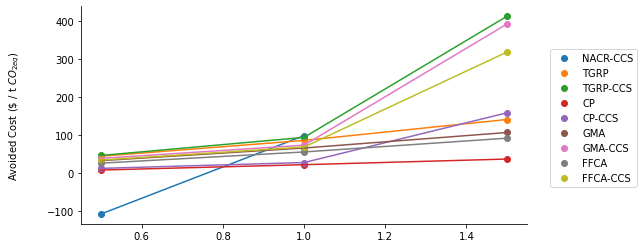

In [14]:
item = "combined"
emit, avct = fetch_data(item, data_map, dbpath)

if emit is not None: # some emission data are not available
    plot_vbar(emit, (8, 4))

if all([x is not None for x in avct]):
    plot_line(*avct, (8, 4))

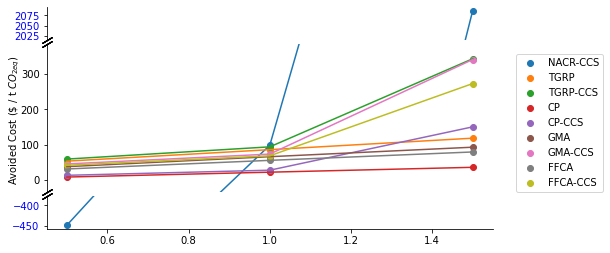

In [15]:
item = "combined_cost"
emit, avct = fetch_data(item, data_map, dbpath)

if emit is not None: # some emission data are not available
    plot_vbar(emit, (8, 4))

if all([x is not None for x in avct]):
    plot_line(*avct, (8, 4), True)

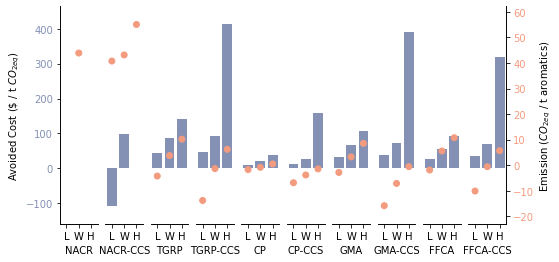

In [16]:
item = "combined_emit_cost"
emit, avct = fetch_data(item, data_map, dbpath)

if emit is not None: # some emission data are not available
    plot_vbar(emit, (8, 4))

if all([x is not None for x in avct]):
    plot_line(*avct, (8, 4), True)